![Logo ITESO](https://www.iteso.mx/image/journal/article?img_id=32346729&t=1662138449889)
# Detección de Neumonía con CNN
*Proyecto de Ciencia de Datos - O2022_MAF3660P*

*[Link al Repositorio de Github](https://github.com/if722399/Proyecto-de-Ciencia-de-Datos)*


Integrantes:
- Haces López, José Manuel - 734759 - Ing. Y Ciencia de Datos
- Navarro Silva, José Tonatiuh - 722399 - Ing. Financiera
____________________
## Exloración de los Datos
### 1. Introducción
- A lo largo de este proyecto se buscará realizar una arquitectura de Redes Neuronales Convolucionales o CNN por sus siglas en inglés. Lo que se busca con ella es poder interpretar una radiografía pulmonar, y de esa forma poder reconocer patrones de Neumonía en los mismos.
- Se usará una base de que cuenta con casi 6,000 imágenes de pulmones, las cuales se identifican en 2 clases, Normal o no infectado y Pneumonia o infectado (se muestran dos tipos de Neumonía, por bacteria o por virus).
  - Los datos se obtuvieron de Kaggle, del usuario 'Alif Rahman'.
  - [Link al Dataset](https://www.kaggle.com/datasets/alifrahman/chestxraydataset?resource=download)

### 2. Antecedentes
- La Clinica Mayo define la Neumonía como, "La neumonía es una infección que inflama los sacos aéreos de uno o ambos pulmones. Los sacos aéreos se pueden llenar de líquido o pus (...), lo que provoca tos con flema o pus, fiebre, escalofríos y dificultad para respirar. (...). La neumonía puede variar en gravedad desde suave a potencialmente mortal. Es más grave en bebés y niños pequeños, personas mayores a 65 años, y personas con problemas de salud o sistemas inmunitarios debilitados." (Neumonía - Síntomas y causas - Mayo Clinic, 2021)

### 3. Objetivos
- Conseguir suficientes imágenes para poder realizar el entrenamiento de manera adecuada.
- Realizar una arquitectura de CNN capaz de identificar de manera eficiente los patrones de Neumonía.
- Crear una API para poder ejecutar nuestro modelo como un Servicio.
- Crear una imagen de Docker para poder ejecutarlo en diferentes instancias.
- Subirlo a la nube para poder ejecutarlo de manera remota.


### 4. Planteamiento del problema
- Se tienen registros del año 460 a.C. en donde Hipócrates describe los síntomas de la enfermedad, lo que nos da a entender que este estado de salud lleva ya varios milenios con nosotros; sin embargo, no la hemos podido erradicar del todo.
- La Neumonía afecta a todas las edades; sin embargo, tenemos dos grupos de riesgo, los niños pequeños y adultos mayores. Lo que ocasiona muchas muertes por esta enfermedad, según Statita (2022) en México en el año de 2020 murieron alrededor de 56,899 personas por Neumonía. Es por ello que mientras más rápido se puedan encontrar indicios de la enfermedad es mucho mejor, para así poder realizar un buen tratamiento de esta.

In [1]:
# LIBRERÍAS
import os
import pickle
import warnings
import numpy as np
import splitfolders
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastcore.parallel import *
from tqdm.notebook import tqdm

# Configuraciones para el Notebook
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### 5. EDA

In [2]:
num_archivos = {'Tipo':[], 'Num_Archivos':[]}
total = 0

# Sacando el Número de archivos por carpeta
for dir in ['NORMAL', 'PNEUMONIA']:
    # Obteniendo el path de los archivos
    path_temp = fr'./data/chest_xray/{dir}'
    # Imprimiendo los resultados
    print(f'- {dir} tiene {len(list(os.listdir(path_temp)))} archivos.')
    total += len(list(os.listdir(path_temp)))
    # Agregando datos al dict
    num_archivos['Tipo'].append(dir)
    num_archivos['Num_Archivos'].append(len(list(os.listdir(path_temp))))

print(f'- Total de Archivos: {total}')

- NORMAL tiene 1575 archivos.
- PNEUMONIA tiene 4265 archivos.
- Total de Archivos: 5840


<BarContainer object of 2 artists>

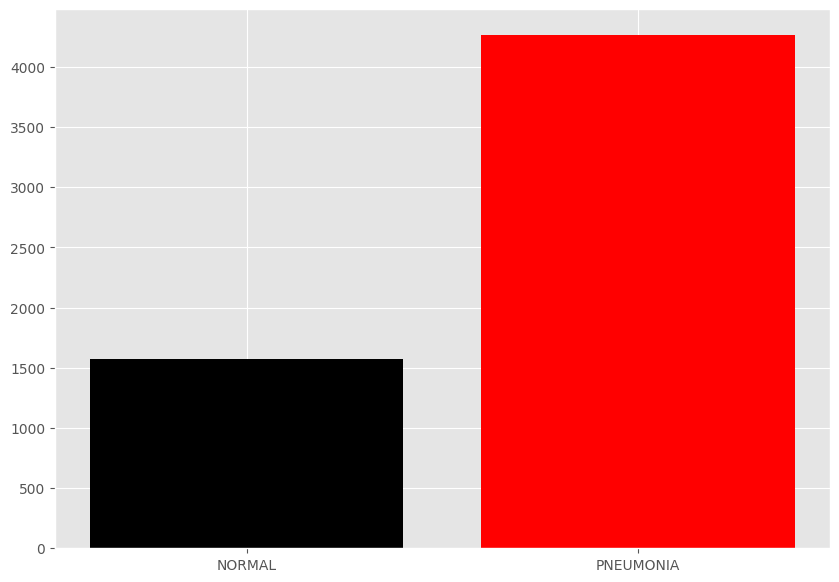

In [3]:
plt.figure(figsize=(10,7))
plt.bar(x=num_archivos['Tipo'], height=num_archivos['Num_Archivos'], color=['black', 'red'])

#### 5.1. Ejemplos de Imágenes
![Ejemplos](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F4298011%2F092cd8598575c60c27fedad4d7998e66%2FjZqpV51.png?generation=1600531874588151&alt=media)

## Modelado
### 1. Dataset
- El dataset cuenta con 5,840 radiografías pulmonares, las cuales se dividen en 2 clases:
  - Normal
  - Pneumonia (infectado)
- El archivo general se encuentra en la carpeta 'data' bajo el nombre de 'chest_xray.zip', el cual tiene un tamaño de 1.13 GB.

### 2. Sepación en Train, Test y Validation
- El archivo se dividirá en 3 directorios con las siguientes jerarquías:
  - Train (97% de las imágenes - 4823 (Esto restando el 15% de validation))
  - Test (3% de las imágenes - 165)
  - Validation (15% de las imágenes de *Train* - 852)

In [ ]:
# Creando las separaciones de los datos de train y test
splitfolders.ratio('./data/chest_xray', output='./data', seed=42, ratio=(0.97, 0, 0.03))

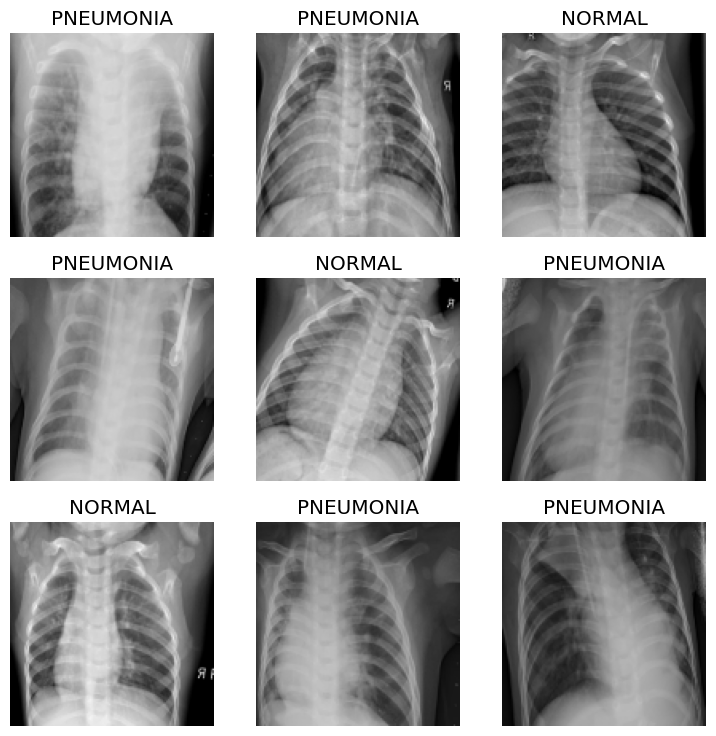

In [4]:
# Creando Train y Validation y rescalando las imágenes
dls = ImageDataLoaders.from_folder('./data/train', valid_pct=0.15, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=9)

### 3. Modelo
- En este notebook no se realizará el entrenamiento del modelo (se realizó en el notebook 'Modelo.ipynb' en el directorio 'model_process'

#### 3.1. Selección de Arquitectura e Hiperparámetros
- Para este proyecto se tomó una arquitectura 'Resnet-26D' pre-entrenada para imágenes, se obtuvo de la librería 'FastAI'.
- Para la selección del 'Learning Rate' se realizó un análisis de valle para buscar el mejor valor.
    - <img src="presentacion/imagenes/Seleccion_Hiperparams_CNN.png">
    - Como podemos ver, el punto más bajo se encuentra en 10^-1, por lo que se usó ese valor.
- Así mismo, se realizaron 30 épocas para el entrenamiento del Modelo.

_____________________________

#### 3.2. Evaluación del Modelo
- <img src="presentacion/imagenes/matriz_confusion.png">
- Para este modelo usaremos como métrica de evaluación el *Recall*, debido a que los *False-Negatives* nos afectan mucho (Se predice 0 (No enferno) y era 1 (enfermo)), lo que nos puede ocasionar que un paciente enfermo no reciba tratamiento.
    - El modelo puede identificar correctamente el 97.14% de los enfermos de manera correcta, el 2.86% restante son False-Negatives (enfermos que se clasifican como no enfermos).

_____________________________

#### 3.3 Carga y Predicción con el Modelo

In [5]:
# Cargando el Modelo
learn = load_learner('CNN_Resnet.pkl', cpu=True)

Prediciendo con Imágenes que no ha visto el modelo

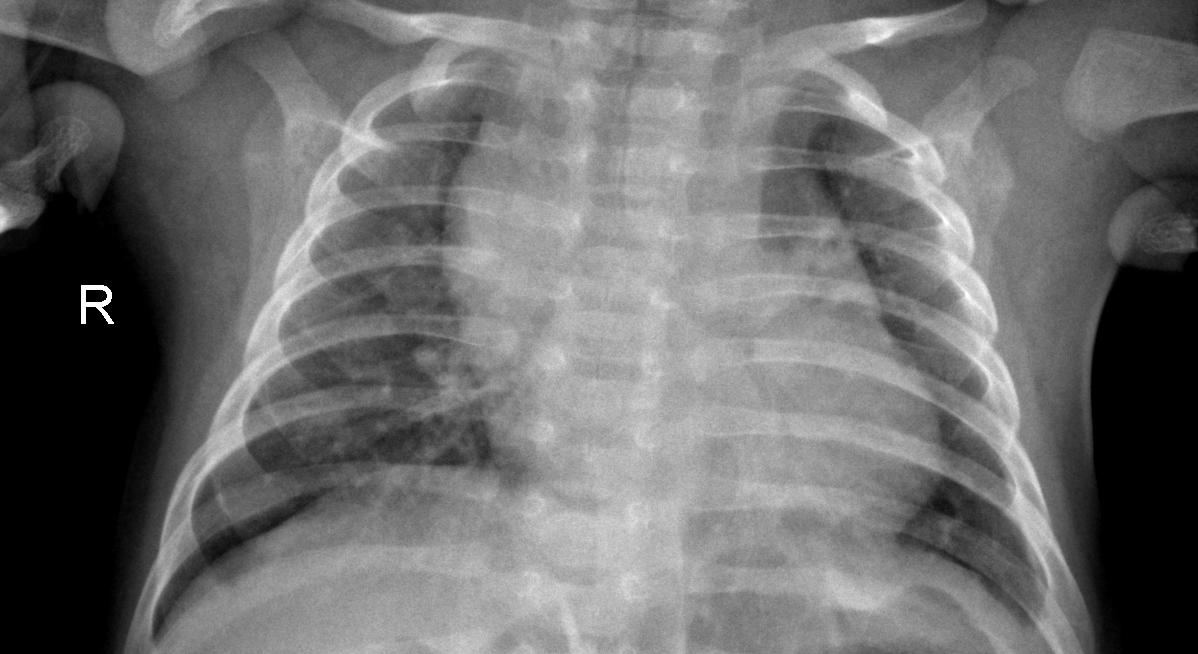

In [9]:
# Mostrando imagen a predecir
Image.open(r'./data/test/PNEUMONIA/person18_virus_49.jpeg')

In [6]:
# Prediciendo una imagen que tiene neumonía
learn.predict(r'./data/test/PNEUMONIA/person18_virus_49.jpeg')[0]

'PNEUMONIA'

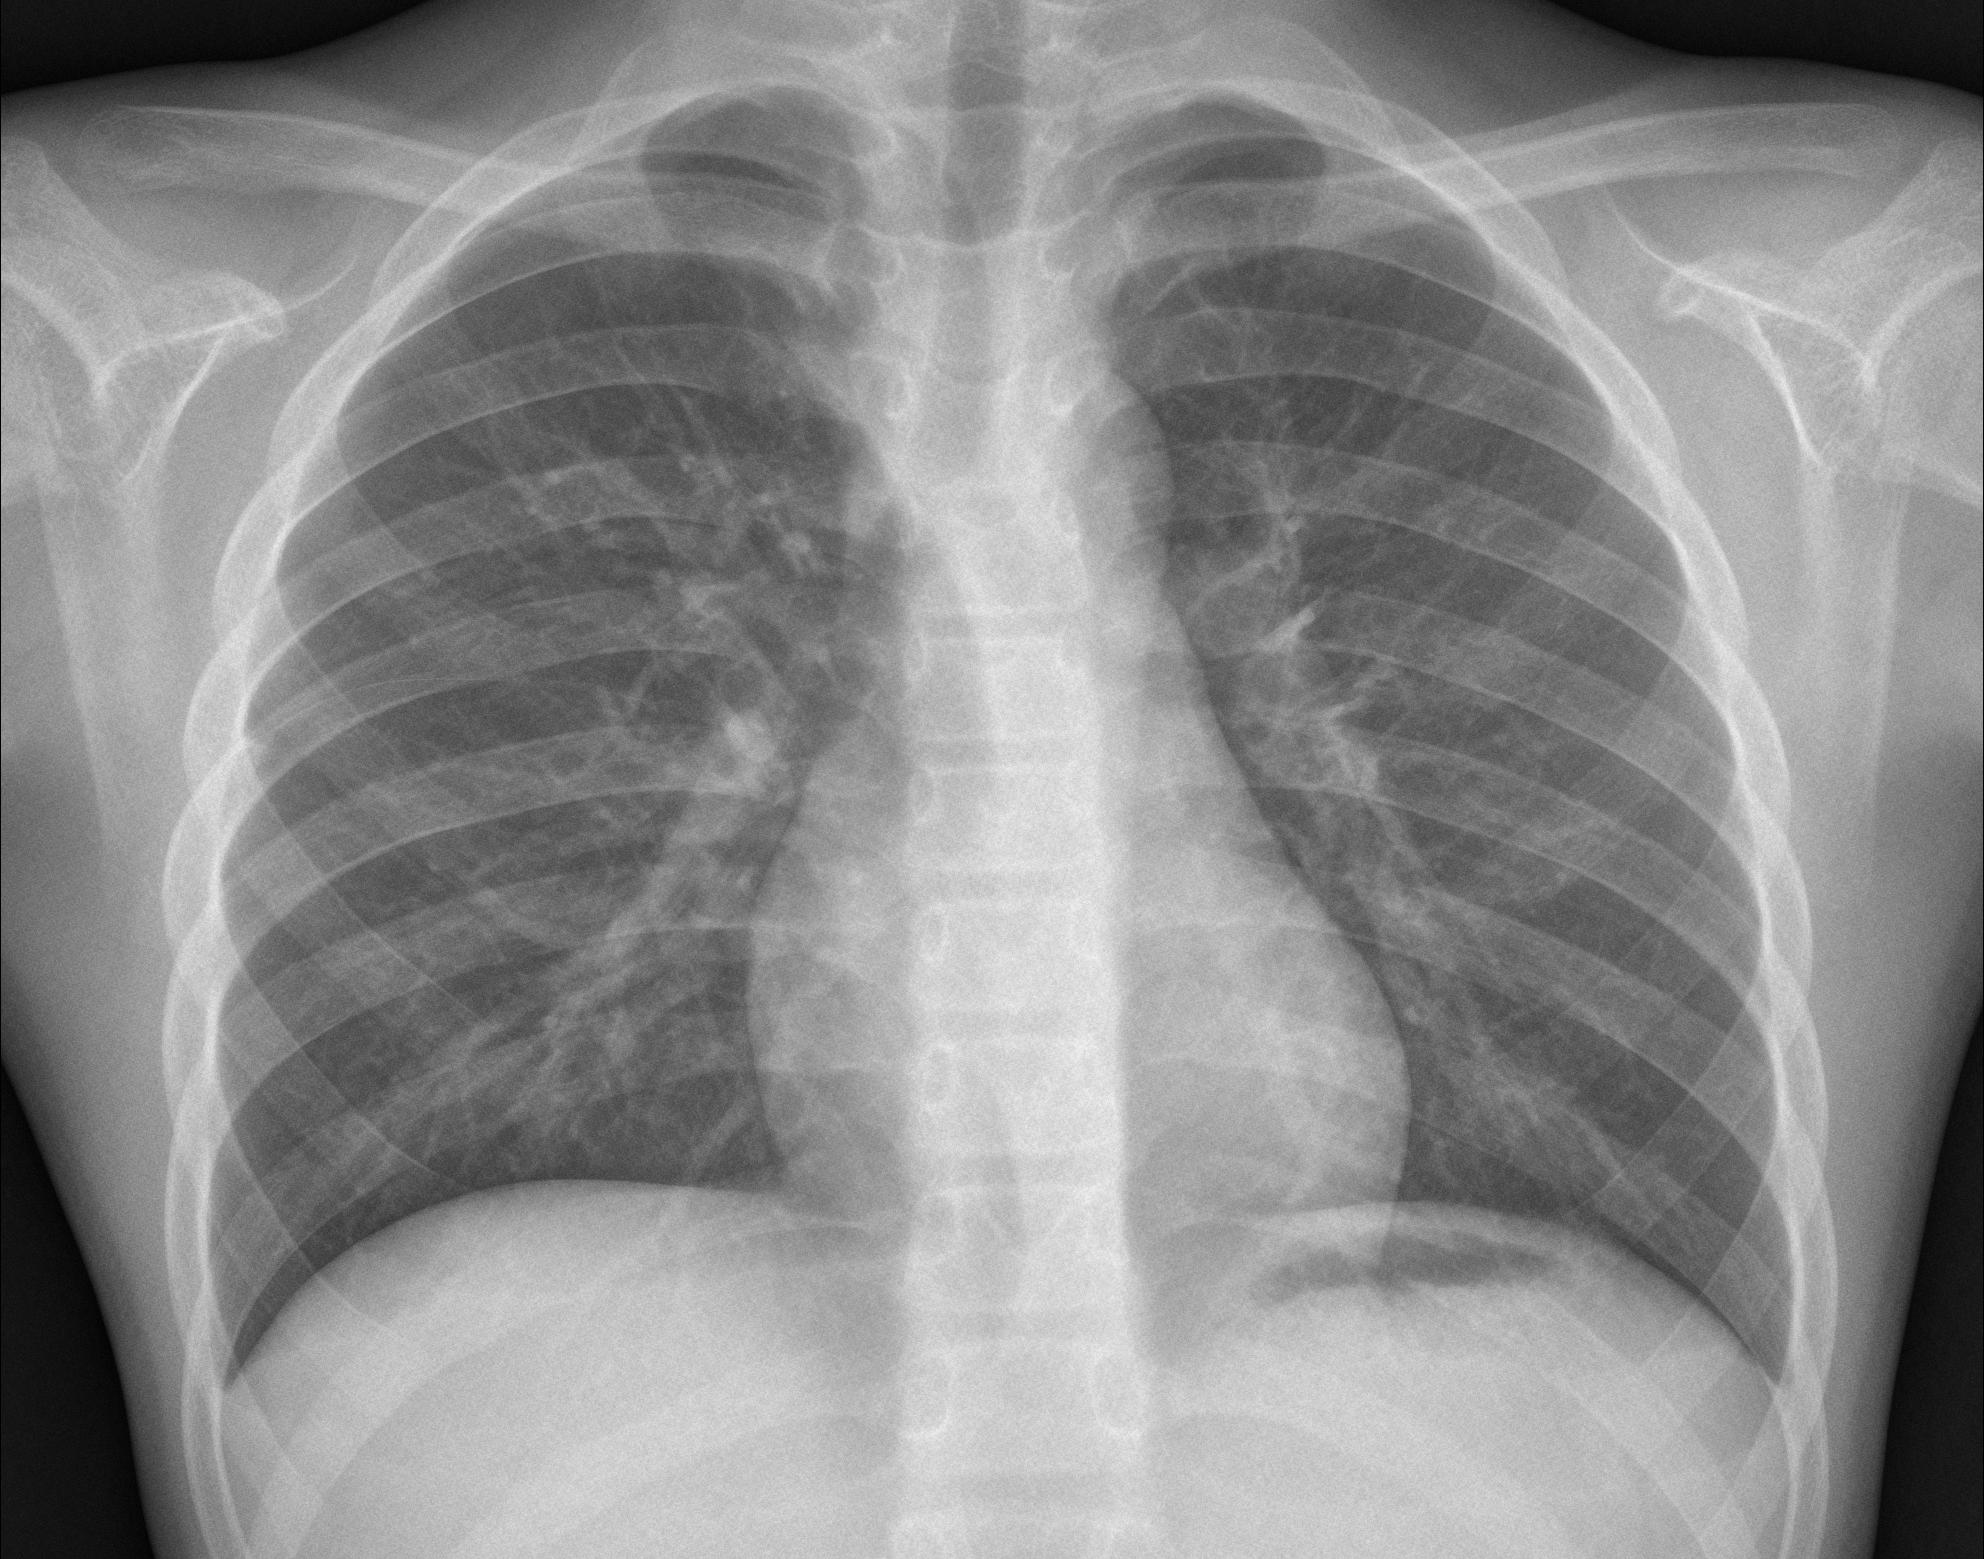

In [10]:
# Mostrando imagen a predecir
Image.open(r'./data/test/NORMAL/IM-0017-0001.jpeg')

In [7]:
# Prediciendo una imagen que NO tiene neumonía
learn.predict(r'./data/test/NORMAL/IM-0017-0001.jpeg')[0]

'NORMAL'

## 4. Correr las Imágenes (Backend y Frontend) - Local
### 4.1. Comando para la construcción de la imagen
-  *docker build -t cnn-app:v1 .*
- <img src="presentacion/imagenes/build_docker.png">

### 4.2. Comando para la ejecución del Backend y Frontend
- Frontend: *docker run -it --rm --name cnn_frontend -v /etc/timezone:/etc/timezone:ro -v /etc/localtime:/etc/localtime:ro -p 8501:8501 cnn-app:v1*
    - <img src="presentacion/imagenes/start_front.png">
- Backend: *docker run -it --rm --name cnn_backend -v /etc/timezone:/etc/timezone:ro -v /etc/localtime:/etc/localtime:ro -p 8001:8001 cnn-app:v1*
    - <img src="presentacion/imagenes/start_back.png">

### 4.3. Ejecución
- Correr Streamlit
    - Correr comando para iniciar Streamlit
    - Correr Comando en la carpeta 'frontened': 'streamlit run cnn-app.py'
        - <img src="presentacion/imagenes/streamlit.png">
    - Seleccionar imagen
        - <img src="presentacion/imagenes/streamlit_1.png">
    - Darle al botón de 'Predict'
        - <img src="presentacion/imagenes/streamlit_2.png">
    - Esperar predicción
        - - <img src="presentacion/imagenes/streamlit_3.png">


## 5. Cloud Computing

### 5.1. Comando para la subida de la imagen a la nube
- Por el tamaño de la imagen se subirá a Docker Hub
    - **Comando**

### 5.2. Dentro de Docker Hub
- **Poner SS**